In [127]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
import collections

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# import defined functions
from src.functions.functions import *

# set the settings for displayed dataFrames
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

### load data

In [128]:
# define path to files
initial_folder_path = "data/initial_data/"
cleaned_folder_path = "data/cleaned_data/"
plot_path = 'plots/'

file_path = cleaned_folder_path + "data_prepared.pkl"

# load data from pickle
data = pd.read_pickle(file_path)

#### create initial returns

In [129]:
# create initial returns
data['Close_price1'] = np.absolute(data['Close_price1'])
data['IR'] = (data['Close_price1']/data['OfferPrice']-1)

#### calculate proceeds

In [130]:
# calculate proceeds incl./excl. overallotment shares
data['proceeds'] = data['ProceedsAmtInThisMktMil']

#### price deflator data - factor 2015 calculation

In [131]:
# factor 2015 calculation 
gdp = pd.read_csv(initial_folder_path + 'GDPDEF.csv')
gdp['DATE'] = pd.to_datetime(gdp['DATE'], format='%Y-%m-%d')
gdp['year'] = gdp['DATE'].dt.year
gdp = gdp.sort_values('DATE')

# only keep first quater
gdp = gdp.drop_duplicates(subset=['year'], keep='first')

# create base level from 2015
gdp['base'] = gdp.loc[gdp['year']==2015, :]['GDPDEF'].values[0]

# create factor every year
gdp['factor'] = gdp['base']/gdp['GDPDEF']

# add gdp information to data
data = pd.merge(data, gdp, left_on='Year', right_on='year', how='left')

# create proceeds in 2015 dollar
data['proceeds_2015'] = data['proceeds']*data['factor']

<font color='grey' > 
  COMMENT
</font>
    
    In the paper, hanley uses 2015 dollars. In the appendix and git code, they uses 2016 dollars.
    Since we try to replicate the given tables and figures, we use the 2015 dollars. 

### Table 1. Mean IPO Initial Returns and Average Proceeds, 1972-2015.

In [132]:
table_1 = data.groupby('Year').agg(
         IPO = ('IPO', 'count'),    # Sum duration per group
         IR = ('IR', np.mean),
         #proceeds_overal = ('proceeds_overall', sum),
         proceeds = ('proceeds', sum),
         proceeds_2015_agg = ('proceeds_2015', sum),
         proceeds_2015_mean = ('proceeds_2015', np.mean))

table_1 = table_1.reset_index()

# create proceeds 2015 mean in mil
table_1['proceeds_2015_mean_mil'] = table_1['proceeds_2015_mean']

# create proceeds 2015 aggregated in mil
table_1['proceeds_2015_agg_mil'] = table_1['proceeds_2015_agg']

table_1_overview = table_1[['Year', 'IPO', 'IR', 'proceeds_2015_mean_mil', 'proceeds_2015_agg_mil']]
print(table_1['IPO'].sum())
print(data['IR'].mean())
print(data['proceeds_2015'].mean())
print(table_1['proceeds_2015_agg_mil'].sum())
print(table_1_overview)

8209
0.17279991479905732
123.98811889758781
1017818.4680303008
    Year  IPO        IR  proceeds_2015_mean_mil  proceeds_2015_agg_mil
0   1973   13  0.116119               27.715263             360.298419
1   1974    3  0.045313               24.972087              74.916260
2   1975    3  0.075228              178.551627             535.654880
3   1976   13  0.042474               29.659108             385.568406
4   1977   10  0.056167               27.811641             278.116413
5   1978   17  0.171262               32.127847             546.173391
6   1979   34  0.104944               22.726575             772.703544
7   1980   52  0.179812               37.835709            1967.456876
8   1981  150  0.062826               32.312679            4846.901828
9   1982   60  0.130394               33.834074            2030.044451
10  1983  395  0.105986               51.796590           20459.652975
11  1984  155  0.025587               27.855698            4317.633188
12  1985  200 

<font color='grey' > 
  COMMENT
</font>
    
    In the paper, in 1995 Hanley et al. output average proceeds (mil) of $ 91.1 mil with 9 companies.
    Here, we have got average proceeds (mil) of $ 178 mil with only 3 companies.

### Figure 1. Number of IPOs and Aggregate Proceeds.

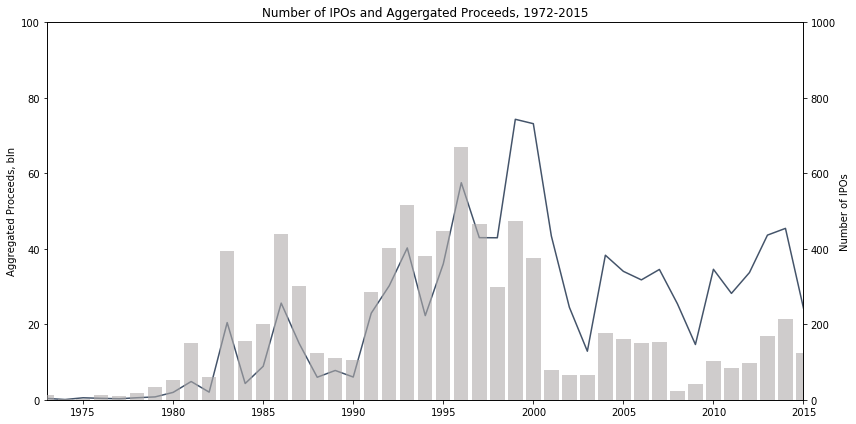

In [133]:
def billions(x, pos):
    return ('{}'.format((x*1e-3).astype(int)))

def figure_1(df, column_1):    
    """
    function to create figure 1
    """
    fmtr = matplotlib.ticker.FuncFormatter(billions)

    fig, ax1 = plt.subplots()
    fig.set_size_inches(12, 6)
    ax1.plot(df['Year'], df[column_1], c='#44546a', zorder=20)
    ax1.set_title('Number of IPOs and Aggergated Proceeds, 1972-2015')
    ax1.set_ylabel('Aggregated Proceeds, bln')
    _ = ax1.yaxis.set_major_formatter(fmtr)
    ax1.set_ylim([0,100000])
    ax1.set_xlim([1973, 2015])

    ax2 = ax1.twinx()
    ax2.bar(df['Year'], height=df['IPO'], color='#afabab', alpha=0.6, zorder=10)
    ax2.set_ylabel('Number of IPOs')
    ax2.set_ylim([0,1000])
    # Rahmen: #222a35
    
    fig.tight_layout()
    plt.savefig(plot_path + 'figure1.png', dpi=300)
    plt.show()
    
# create figure 1
figure_1(df=table_1, column_1='proceeds_2015_agg')

### Figure 2. Number of IPOs and Initial Returns.

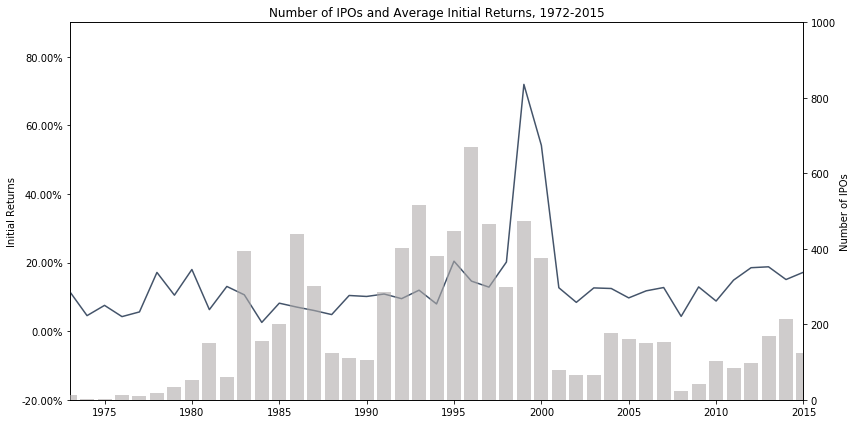

In [134]:
def figure_2(df):
    """
    function to create figure 2
    """
    fig, ax1 = plt.subplots()
    fig.set_size_inches(12, 6)
    ax1.plot(df['Year'], df['IR'], c='#44546a', zorder=20)
    ax1.set_title('Number of IPOs and Average Initial Returns, 1972-2015')
    ax1.set_ylabel('Initial Returns')
    ax1.set_ylim([-0.2,0.9])
    ax1.set_xlim([1973, 2015])
    vals = ax1.get_yticks()
    ax1.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

    ax2 = ax1.twinx()
    ax2.bar(df['Year'], height=df['IPO'], color='#afabab', alpha=0.6, zorder=10)
    ax2.set_ylabel('Number of IPOs')
    ax2.set_ylim([0,1000])
    # Rahmen: #222a35
    
    fig.tight_layout()
    plt.savefig(plot_path + 'figure2.png', dpi=300)
    plt.show()

figure_2(df = table_1)

### Figure 3. Initial Returns and Aggregate Proceeds.

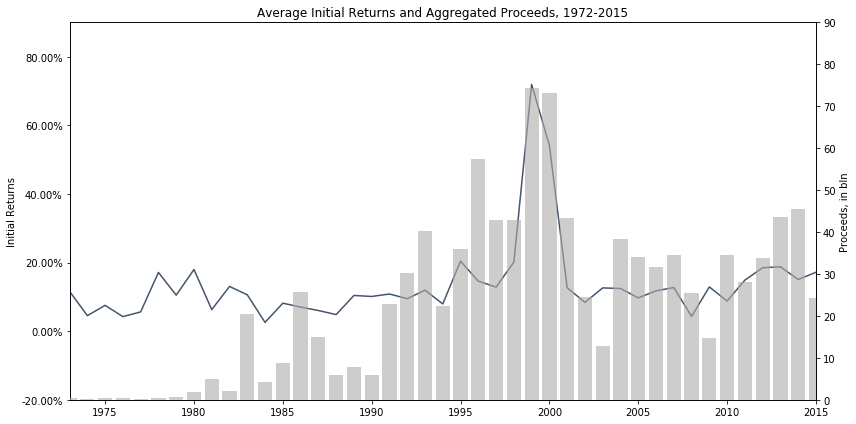

In [135]:
def figure_3(df):
    """
    function to create figure 3
    """
    fmtr = matplotlib.ticker.FuncFormatter(billions)
    
    fig, ax1 = plt.subplots()
    fig.set_size_inches(12, 6)
    ax1.plot(df['Year'], df['IR'], c='#44546a', zorder=20)
    ax1.set_title('Average Initial Returns and Aggregated Proceeds, 1972-2015')
    ax1.set_ylabel('Initial Returns')
    ax1.set_ylim([-0.2,0.9])
    ax1.set_xlim([1973, 2015])
    vals = ax1.get_yticks()
    ax1.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

    ax2 = ax1.twinx()
    ax2.bar(df['Year'], height=df['proceeds_2015_agg'], color='#afabab', alpha=0.6, zorder=10)
    ax2.set_ylabel('Proceeds, in bln')
    ax2.set_ylim([0,90000])
    _ = ax2.yaxis.set_major_formatter(fmtr)
    # Rahmen: #222a35
    
    fig.tight_layout()
    plt.savefig(plot_path + 'figure3.png', dpi=300)
    plt.show()

figure_3(df = table_1)

### Table 2. IPO Initial Returns by the Proceeds Amount, 1972-2015.

In [136]:
data['size'] = 'N'
data.loc[(data['proceeds_2015'] <= 30), 'size'] = 'S'
data.loc[(data['proceeds_2015'] > 30) & (data['proceeds_2015'] <= 120), 'size'] = 'M'
data.loc[data['proceeds_2015'] > 120, 'size'] = 'L'

data.loc[data['size'] == 'S', 'IR_30mln'] = data['IR']
data.loc[data['size'] == 'M', 'IR_30to120mln'] = data['IR']
data.loc[data['size'] == 'L', 'IR_120mln'] = data['IR']

data.loc[data['size'] == 'S', 'IPO_30mln'] = True
data.loc[data['size'] == 'M', 'IPO_30mto120mln'] = True
data.loc[data['size'] == 'L', 'IPO_120mln'] = True

print(collections.Counter(data['size']))

table_2 = data.groupby(['Year']).agg(
    IPO = ('IPO', 'count'),
    IR_30mln = ('IR_30mln', np.mean),
    IR_30to120mln = ('IR_30to120mln', np.mean),
    IR_120mln = ('IR_120mln', np.mean),
    IPO_30mln = ('IPO_30mln', sum),
    IPO_30mto120mln = ('IPO_30mto120mln', sum),
    IPO_120mln = ('IPO_120mln', sum))

table_2 = table_2.reset_index()

print(table_2)

Counter({'M': 4038, 'S': 2469, 'L': 1702})
    Year  IPO  IR_30mln  IR_30to120mln  IR_120mln  IPO_30mln  IPO_30mto120mln  \
0   1973   13  0.088621       0.267361        NaN         11                2   
1   1974    3  0.060826       0.014286        NaN          2                1   
2   1975    3  0.190000       0.043750  -0.008065          1                1   
3   1976   13  0.020648       0.091580        NaN          9                4   
4   1977   10  0.062132       0.032310        NaN          8                2   
5   1978   17  0.198315       0.147216        NaN          8                9   
6   1979   34  0.087530       0.161539        NaN         26                8   
7   1980   52  0.136251       0.253055   0.190492         31               18   
8   1981  150  0.068974       0.053447   0.010000         99               48   
9   1982   60  0.108001       0.160905   0.446429         40               19   
10  1983  395  0.118699       0.096098   0.078316        198      

### Figure 4. IPO Initial Returns and Proceeds.

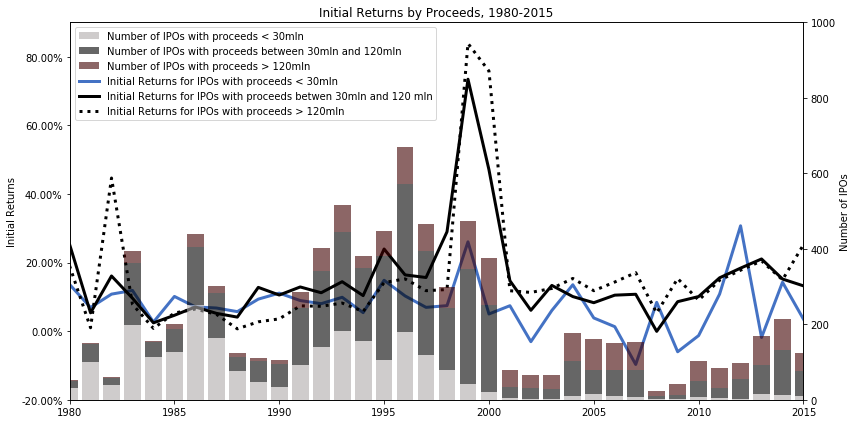

In [137]:
def figure_4(df, linewidth=3):
    """
    function to create figure 4
    """
    fig, ax1 = plt.subplots()
    fig.set_size_inches(12, 6)
    ln1 = ax1.plot(df['Year'], df['IR_30mln'], c='#4472c4', linewidth=linewidth, label='Initial Returns for IPOs with proceeds < 30mln')
    ln2 = ax1.plot(df['Year'], df['IR_30to120mln'], c='#000000', linewidth=linewidth, label='Initial Returns for IPOs with proceeds betwen 30mln and 120 mln')
    ln3 = ax1.plot(df['Year'], df['IR_120mln'], c='#000000', linestyle=':', linewidth=linewidth, label='Initial Returns for IPOs with proceeds > 120mln')
    ax1.set_title('Initial Returns by Proceeds, 1980-2015')
    ax1.set_ylabel('Initial Returns')
    ax1.set_ylim([-0.2,0.9])
    ax1.set_xlim([1980, 2015])
    vals = ax1.get_yticks()
    ax1.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

    ax2 = ax1.twinx()
    bar1 = ax2.bar(df['Year'], height=df['IPO_30mln'], 
            color='#afabab', alpha=0.6, 
            label='Number of IPOs with proceeds < 30mln')
    bar2 = ax2.bar(df['Year'], height=df['IPO_30mto120mln'], 
            bottom=df['IPO_30mln'], color='#000000', alpha=0.6,
           label='Number of IPOs with proceeds between 30mln and 120mln', 
           )
    bar3 = ax2.bar(df['Year'], height=df['IPO_120mln'], 
            bottom=df['IPO_30mto120mln']+df['IPO_30mln'], 
            color='#400000', alpha=0.6,
           label='Number of IPOs with proceeds > 120mln')
    ax2.set_ylabel('Number of IPOs')
    ax2.set_ylim([0,1000])
    
    lines, labels = ax1.get_legend_handles_labels()
    bars, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(bars + lines, labels2 + labels, loc='upper left')
    
    #### TODO: legend outside of the box ####
    # Shrink current axis's height by 10% on the bottom
    #box = ax1.get_position()
    #ax1.set_position([box.x0, box.y0 + box.height,
    #box.width, box.height * 0.9])

    # Put a legend below current axis
    #ax1.legend(lines + bars, labels + labels2,
    #           loc='upper center', bbox_to_anchor=(0.5, -0.05),
    #          fancybox=True, shadow=True, ncol=5)

    fig.tight_layout()
    plt.savefig(plot_path + 'figure4.png', dpi=300)
    plt.show()

linewidth=3
figure_4(df = table_2, linewidth=linewidth)

### Table 3. Initial Returns and the Initial Price Range, 1983-2015.

In [138]:
# inspect price columns
# price_cols = find_char_in_colnames(data, 'Price')
# print(data[price_cols].isna().sum())

# create constructed_low and constructed_low
data['Issued_priced_range'] = np.nan

data.loc[(data['Year']>=1983) & 
         (data['OriginalLowFilingPrice'].notna()), 
         'constructed_low'] = data['OriginalLowFilingPrice']

data.loc[(data['Year']>=1983) & 
         (data['OriginalHighFilingPrice'].notna()), 
         'constructed_high'] = data['OriginalHighFilingPrice']

In [139]:
# info from HistoryLowFilingPrice/HistoryHighFilingPrice (amendment price history list) variables
def get_first_price(price_hist):
    """
    returns the first price per day in the given history
    """
    split_list = price_hist.str.split('|', expand=True)
    split_list = split_list[0]
    split_list = pd.to_numeric(split_list)
    return(split_list)

low_hist = data.loc[(data['Year']>=1996) & 
                    (data['constructed_low'].isna()), 
                    'HistoryLowFilingPrice']
low_hist_first = get_first_price(low_hist)
data.loc[(data['Year']>=1996) & 
         (data['constructed_low'].isna()), 
         'constructed_low'] = low_hist_first

high_hist = data.loc[(data['Year']>=1996) & 
                     (data['constructed_high'].isna()), 
                     'HistoryHighFilingPrice']
high_hist_first = get_first_price(high_hist)
data.loc[(data['Year']>=1996) & 
         (data['constructed_high'].isna()), 
         'constructed_high'] = high_hist_first

In [140]:
# create the attributes under range/ within range/ above range
not_missing = (data['constructed_low'].notna() & data['constructed_high'].notna())
sum_constructed = (data['constructed_low'] + data['constructed_high'])
dif_constructed = (data['constructed_low'] - data['constructed_high'])
min_range = 0.5*sum_constructed - np.abs(0.5*dif_constructed)
max_range = 0.5*sum_constructed + np.abs(0.5*dif_constructed)

In [141]:
# create the attributes under range/ within range/ above range
data.loc[not_missing & (data['OfferPrice'] < min_range), 
         'Issue_priced_range'] = 'Below range'
data.loc[not_missing & (data['OfferPrice'] >= min_range) & 
         (data['OfferPrice'] <= max_range), 
         'Issue_priced_range'] = 'Within range'
data.loc[not_missing & (data['OfferPrice'] > max_range), 
         'Issue_priced_range'] = 'Above range'

# get some stats
print(data['Issue_priced_range'].isna().sum())
print(data['Issue_priced_range'].notna().sum())
print(collections.Counter(data.loc[data['Issue_priced_range'].notna(), 'Issue_priced_range']))

769
7440
Counter({'Within range': 3742, 'Below range': 1989, 'Above range': 1709})


In [142]:
#create table 3
data.loc[data['Issue_priced_range'] == 'Below range', 'below_range'] = 1
data.loc[data['Issue_priced_range'] == 'Within range', 'within_range'] = 1
data.loc[data['Issue_priced_range'] == 'Above range', 'above_range'] = 1
data.loc[data['Issue_priced_range'] == 'Below range', 'IR_below_range'] = data['IR']
data.loc[data['Issue_priced_range'] == 'Within range', 'IR_within_range'] = data['IR']
data.loc[data['Issue_priced_range'] == 'Above range', 'IR_above_range'] = data['IR']

table_3 = data.groupby(['Year']).agg(
    IPO = ('Issue_priced_range', 'count'),
    IR_below_range = ('IR_below_range', np.mean),
    IR_within_range = ('IR_within_range', np.mean),
    IR_above_range = ('IR_above_range', np.mean),
    below_range = ('below_range', sum),
    within_range = ('within_range', sum),
    above_range = ('above_range', sum))

table_3 = table_3.reset_index()
table_3 = table_3.loc[table_3['Year']>=1983, :]

In [143]:
table_3

,Year,IPO,IR_below_range,IR_within_range,IR_above_range,below_range,within_range,above_range
10,1983,299,0.024530,0.119706,0.242849,84.0,168.0,47.0
11,1984,115,0.017607,0.030365,0.116636,57.0,55.0,3.0
12,1985,170,0.029414,0.086645,0.135778,40.0,119.0,11.0
13,1986,362,0.002638,0.076213,0.257732,78.0,269.0,15.0
14,1987,249,0.002891,0.064820,0.178634,60.0,173.0,16.0
15,1988,93,0.020549,0.074895,0.070990,20.0,69.0,4.0
16,1989,107,0.017265,0.115522,0.135717,18.0,64.0,25.0
17,1990,102,0.037201,0.073695,0.223633,21.0,56.0,25.0
18,1991,283,0.014237,0.109573,0.192738,58.0,162.0,63.0
19,1992,396,0.022384,0.091309,0.218586,135.0,177.0,84.0


In [144]:
print(data['below_range'].sum())
print(data['within_range'].sum())
print(data['above_range'].sum())

1989.0
3742.0
1709.0


### Figure 5. IPO Initial Returns and Initial Price Range.

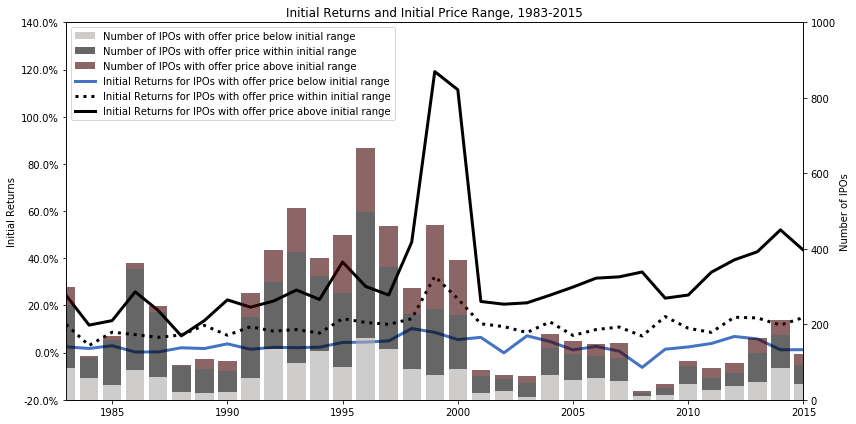

In [145]:
def figure_5(df, linewidth=3):
    """
    function to create figure 5
    """
    fig, ax1 = plt.subplots()
    fig.set_size_inches(12, 6)
    ln1 = ax1.plot(df['Year'], df['IR_below_range'], c='#4472c4', 
                   linewidth=linewidth, 
                   label='Initial Returns for IPOs with offer price below initial range')
    ln2 = ax1.plot(df['Year'], df['IR_within_range'], 
                   c='#000000', linewidth=linewidth, linestyle=':',
                   label='Initial Returns for IPOs with offer price within initial range')
    ln3 = ax1.plot(df['Year'], df['IR_above_range'], 
                   c='#000000', linewidth=linewidth, 
                   label='Initial Returns for IPOs with offer price above initial range')
    ax1.set_title('Initial Returns and Initial Price Range, 1983-2015')
    ax1.set_ylabel('Initial Returns')
    ax1.set_ylim([-0.2,1.4])
    ax1.set_xlim([1983, 2015])
    vals = ax1.get_yticks()
    ax1.set_yticklabels(['{:,.1%}'.format(x) for x in vals])

    ax2 = ax1.twinx()
    bar1 = ax2.bar(df['Year'].values, height=df['below_range'].values, 
                   color='#afabab', alpha=0.6, 
                   label='Number of IPOs with offer price below initial range')
    bar2 = ax2.bar(df['Year'].values, height=df['within_range'].values, 
                   color='#000000', alpha=0.6, bottom=df['below_range'].values,
                   label='Number of IPOs with offer price within initial range')  
    bar3 = ax2.bar(df['Year'].values, height=df['above_range'].values,
                   bottom=(df['within_range']+df['below_range']).values, 
                   color='#400000', alpha=0.6,
                   label='Number of IPOs with offer price above initial range')
    ax2.set_ylabel('Number of IPOs')
    ax2.set_ylim([0,1000])
    
    lines, labels = ax1.get_legend_handles_labels()
    bars, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(bars + lines, labels2 + labels, loc='upper left')
    
    #### TODO: legend outside of the box ####
    # Shrink current axis's height by 10% on the bottom
    #box = ax1.get_position()
    #ax1.set_position([box.x0, box.y0 + box.height,
    #box.width, box.height * 0.9])

    # Put a legend below current axis
    #ax1.legend(lines + bars, labels + labels2,
    #           loc='upper center', bbox_to_anchor=(0.5, -0.05),
    #          fancybox=True, shadow=True, ncol=5)

    fig.tight_layout()
    plt.savefig(plot_path + 'figure5.png', dpi=300)
    plt.show()

linewidth=3
figure_5(df = table_3, linewidth=linewidth)

### Table 4. Mean Initial Return for IPOs with and without Venture Capitalist Backing, 1972-2015.

##### <font color='red'> NOT YET FINISHED: firm age </font>

### get data about IPO age from Jay Ritter website
firm_age = pd.read_csv(initial_folder_path + 'age7516.csv', header=0, delimiter=';')

firm_age = firm_age.loc[firm_age['Founding'] != -99, :]
firm_age.loc[firm_age['CRSP perm']=='.', 'CRSP perm'] = np.nan

firm_age['CRSP perm'] = firm_age['CRSP perm'].apply(lambda col:pd.to_numeric(col, errors='coerce'))

firm_age.isna().sum()

firm_age = firm_age.loc[firm_age['CRSP perm'].notna() & firm_age['CRSP perm'].duplicated(), :]

firm_age = firm_age.loc[(firm_age['CRSP perm'] != -99) &
                        (firm_age['CRSP perm'] != 999) &
                        (firm_age['CRSP perm'] != 0) &
                        (firm_age['CRSP perm'] != -9 &
                        (firm_age['CRSP perm'] != 99999)), :]

print(len(data))
#test = pd.merge(data, firm_age, how='left', left_on=['PERMNO'], right_on=['CRSP perm'])
test = pd.merge(data, firm_age, how='left', left_on=['CUSIP8'], right_on=['CUSIP'])
print(len(test))
print(len(test.loc[test['Founding'].isna(), :])

##### VC backed
##### <font color='red'> NOT YET RIGHT: tech percentage </font>

In [146]:
# create tech company attribute
data['tech'] = 0
data.loc[data['PrimaryHiTechIndustryCode']>0, 'tech'] = 1

data['tech_VC'] = 0
data['tech_no_VC'] = 0

# create vc backed attributes
data.loc[data['VentureBacked']== 'No','no_VC'] = 1
data.loc[data['VentureBacked']== 'Yes','yes_VC'] = 1
data.loc[data['VentureBacked']== 'No','IR_no_VC'] = data['IR']
data.loc[data['VentureBacked']== 'Yes','IR_VC'] = data['IR']
data.loc[(data['VentureBacked']== 'Yes') & data['tech']==1,'tech_VC'] = 1
data.loc[(data['VentureBacked']== 'No') & data['tech']==1,'tech_no_VC'] = 1

for col in ['no_VC', 'yes_VC', 'IR_no_VC', 'IR_VC', 'tech_VC', 'tech_no_VC']:
    data[col] = data[col].apply(lambda col:pd.to_numeric(col, errors='coerce'))

table_4 = data.groupby(['Year']).agg(
    IPO = ('IssueDate', 'count'),
    no_VC = ('no_VC', sum),
    VC = ('yes_VC', sum),
    IR_no_VC = ('IR_no_VC', np.mean),
    IR_VC = ('IR_VC', np.mean),
    tech_VC = ('tech_VC', np.mean),
    tech_no_VC = ('tech_no_VC', np.mean))

#table_4['tech_VC_perc'] = table_4['tech_VC']/table_4['IPO']
#table_4['tech_no_VC_perc'] = table_4['tech_no_VC']/table_4['IPO']

table_4 = table_4.reset_index()
table_4

,Year,IPO,no_VC,VC,IR_no_VC,IR_VC,tech_VC,tech_no_VC
0,1973,13,11.0,2.0,0.101531,0.196354,0.153846,0.307692
1,1974,3,2.0,1.0,0.018862,0.098214,0.333333,0.000000
2,1975,3,3.0,0.0,0.075228,NaN,0.000000,0.333333
3,1976,13,7.0,6.0,0.021138,0.067365,0.307692,0.230769
4,1977,10,9.0,1.0,0.028592,0.304348,0.100000,0.000000
5,1978,17,8.0,9.0,0.107979,0.227514,0.470588,0.117647
6,1979,34,21.0,13.0,0.067982,0.164651,0.264706,0.176471
7,1980,52,28.0,24.0,0.119362,0.250337,0.346154,0.192308
8,1981,150,97.0,53.0,0.051095,0.084295,0.240000,0.200000
9,1982,60,38.0,22.0,0.117681,0.152353,0.350000,0.250000


### Figure 6. IPO Initial Returns and Venture Capital Backing.

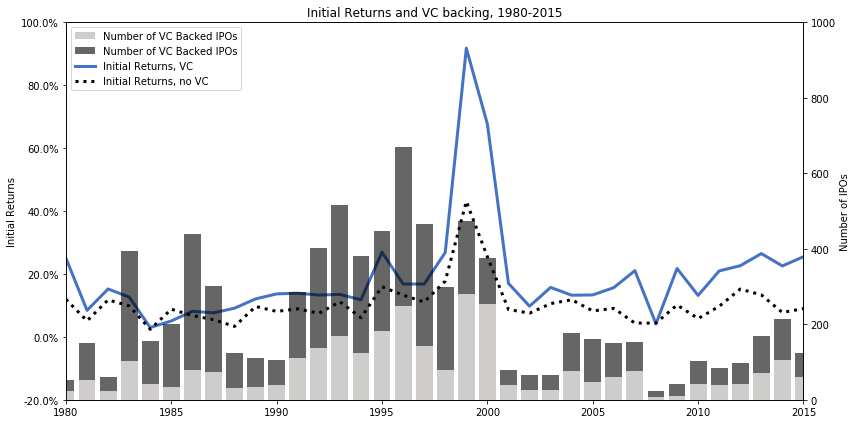

In [147]:
def figure_6(df, linewidth=3):
    """
    function to create figure 5
    """
    fig, ax1 = plt.subplots()
    fig.set_size_inches(12, 6)
    ln1 = ax1.plot(df['Year'], df['IR_VC'], c='#4472c4', 
                   linewidth=linewidth, 
                   label='Initial Returns, VC')
    ln2 = ax1.plot(df['Year'], df['IR_no_VC'], 
                   c='#000000', linewidth=linewidth, linestyle=':',
                   label='Initial Returns, no VC')
    ax1.set_title('Initial Returns and VC backing, 1980-2015')
    ax1.set_ylabel('Initial Returns')
    ax1.set_ylim([-0.2,1])
    ax1.set_xlim([1980, 2015])
    vals = ax1.get_yticks()
    ax1.set_yticklabels(['{:,.1%}'.format(x) for x in vals])

    ax2 = ax1.twinx()
    bar1 = ax2.bar(df['Year'].values, height=df['VC'].values, 
                   color='#afabab', alpha=0.6, 
                   label='Number of VC Backed IPOs')
    bar2 = ax2.bar(df['Year'].values, height=df['no_VC'].values, 
                   color='#000000', alpha=0.6, bottom=df['VC'].values,
                   label='Number of VC Backed IPOs')  
    ax2.set_ylabel('Number of IPOs')
    ax2.set_ylim([0,1000])
    
    lines, labels = ax1.get_legend_handles_labels()
    bars, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(bars + lines, labels2 + labels, loc='upper left')
    
    #### TODO: legend outside of the box ####
    # Shrink current axis's height by 10% on the bottom
    #box = ax1.get_position()
    #ax1.set_position([box.x0, box.y0 + box.height,
    #box.width, box.height * 0.9])

    # Put a legend below current axis
    #ax1.legend(lines + bars, labels + labels2,
    #           loc='upper center', bbox_to_anchor=(0.5, -0.05),
    #          fancybox=True, shadow=True, ncol=5)

    fig.tight_layout()
    plt.savefig(plot_path + 'figure6.png', dpi=300)
    plt.show()

linewidth=3
figure_6(df = table_4, linewidth=linewidth)

### Table 5. IPO Initial Returns and Underwriter Spread, 1980-2015.

In [148]:
# clean GrossSpreadAsOfPrncplAmtInThisMkt
data.loc[:, 'GrossSpreadAsOfPrncplAmtInThisMkt'] = data['GrossSpreadAsOfPrncplAmtInThisMkt'].str.replace('na', 'NaN')
data = convert_NAs(data, 'GrossSpreadAsOfPrncplAmtInThisMkt')
data['GrossSpreadAsOfPrncplAmtInThisMkt'] = pd.to_numeric(data['GrossSpreadAsOfPrncplAmtInThisMkt'], errors='raise')

# create variables for less, equal and more than 7 percent gross spread
data['gross_spread'] = data['GrossSpreadAsOfPrncplAmtInThisMkt']
data.loc[(data['gross_spread'] < 7), 'gs_less7'] = data['gross_spread']
data.loc[(data['gross_spread'] == 7) , 'gs_eq7'] = data['gross_spread']
data.loc[data['gross_spread'] > 7, 'gs_more7'] = data['gross_spread']

# create variables for gross spread depending on the proceed size
data.loc[data['size'] == 'S', 'gs_s'] = data['gross_spread']
data.loc[data['size'] == 'M', 'gs_m'] = data['gross_spread']
data.loc[data['size'] == 'L', 'gs_l'] = data['gross_spread']

# create table 5 structure and content
table_5 = data.groupby(['Year']).agg(
    IPO = ('IPO', 'count'),
    gross_count = ('gross_spread', 'count'),
    gs_less7 = ('gs_less7', 'count'),
    gs_eq7 = ('gs_eq7', 'count'),
    gs_more7 = ('gs_more7', 'count'),
    gs_s = ('gs_s', np.mean),
    gs_m = ('gs_m', np.mean),
    gs_l = ('gs_l', np.mean))

# create variables relative to gross count
table_5['gs_less7'] = table_5['gs_less7']/table_5['gross_count']
table_5['gs_eq7'] = table_5['gs_eq7']/table_5['gross_count']
table_5['gs_more7'] = table_5['gs_more7']/table_5['gross_count']

table_5 = table_5.reset_index()

# take only data since 1980
table_5 = table_5.loc[table_5['Year']>=1980, :]

# show table
table_5

64 NAs have been created. 8145 valid values are left. 



,Year,IPO,gross_count,gs_less7,gs_eq7,gs_more7,gs_s,gs_m,gs_l
7,1980,52,52,0.096154,0.038462,0.865385,8.198387,7.188444,5.969667
8,1981,150,150,0.126667,0.046667,0.826667,8.096333,7.177771,6.298333
9,1982,60,60,0.100000,0.116667,0.783333,8.190300,7.060632,7.000000
10,1983,395,395,0.329114,0.154430,0.516456,7.968414,6.920782,6.205875
11,1984,155,155,0.129032,0.174194,0.696774,7.816693,6.968000,6.605000
12,1985,200,200,0.250000,0.115000,0.635000,8.060512,6.916567,6.208615
13,1986,440,440,0.331818,0.140909,0.527273,7.790199,6.887052,5.993618
14,1987,301,301,0.302326,0.219269,0.478405,7.691245,6.903815,5.665895
15,1988,123,123,0.292683,0.308943,0.398374,7.440184,6.820711,5.774667
16,1989,112,112,0.250000,0.410714,0.339286,7.795271,6.942019,5.624700


### Figure 7. Underwriter Spread.

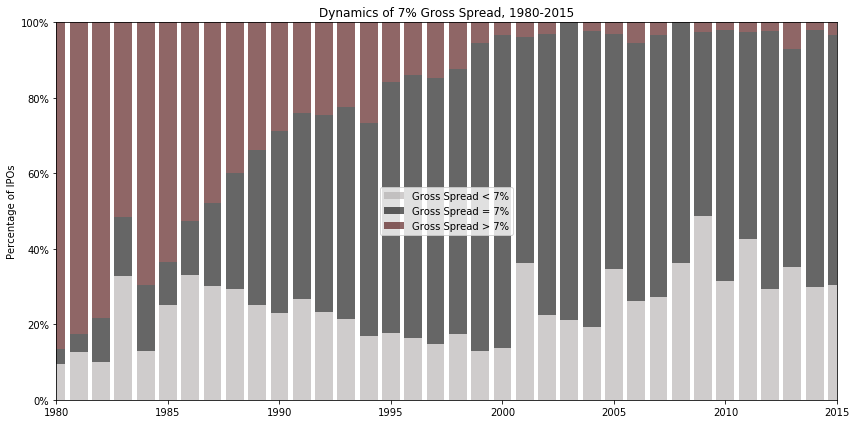

In [149]:
def figure_7(df):
    """
    function to create figure 7
    """
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 6)
    ax.set_title('Dynamics of 7% Gross Spread, 1980-2015')
    ax.set_ylabel('Percentage of IPOs')
    ax.set_ylim([0,1])
    ax.set_xlim([1980, 2015])
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
    
    bar1 = ax.bar(df['Year'].values, height=df['gs_less7'].values, 
                   color='#afabab', alpha=0.6, 
                   label='Gross Spread < 7%')
    bar2 = ax.bar(df['Year'].values, height=df['gs_eq7'].values, 
                   color='#000000', alpha=0.6, bottom=df['gs_less7'].values,
                   label='Gross Spread = 7%')
    bar3 = ax.bar(df['Year'].values, height=df['gs_more7'].values, 
                   color='#440000', alpha=0.6, bottom=(df['gs_less7'].values + df['gs_eq7'].values),
                   label='Gross Spread > 7%')  
    ax.legend()
    
    fig.tight_layout()
    plt.savefig(plot_path + 'figure7.png', dpi=300)
    plt.show()

figure_7(df = table_5)

### Figure 8. Average Underwriter Spread and IPO proceeds.

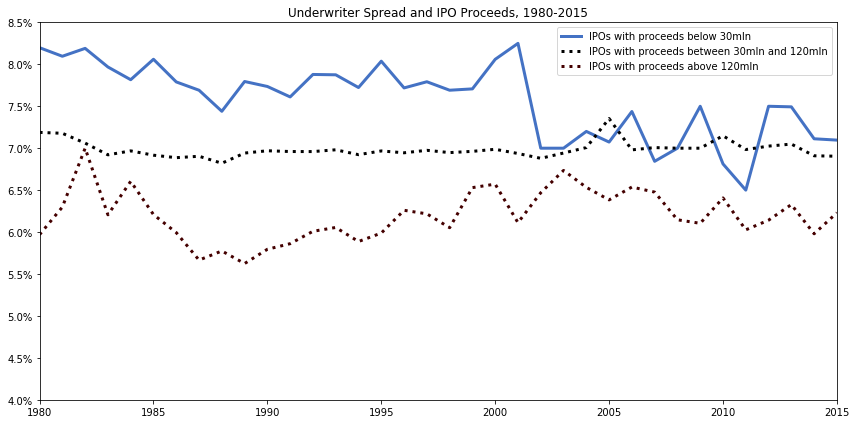

In [150]:
def figure_8(df, linewidth):
    """
    function to create figure 8
    """
    
    fmtr = matplotlib.ticker.PercentFormatter(decimals=1)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 6)
    ax.set_title('Underwriter Spread and IPO Proceeds, 1980-2015')
    ax.set_ylim([4,8.5])
    ax.set_xlim([1980, 2015])
    #vals = ax.get_yticks()
    matplotlib.ticker.PercentFormatter()
    #ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
    ln1 = ax.plot(df['Year'], df['gs_s'], c='#4472c4', 
                   linewidth=linewidth, 
                   label='IPOs with proceeds below 30mln')
    ln2 = ax.plot(df['Year'], df['gs_m'], 
                   c='#000000', linewidth=linewidth, linestyle=':',
                   label='IPOs with proceeds between 30mln and 120mln')
    ln3 = ax.plot(df['Year'], df['gs_l'], 
                   c='#440000', linewidth=linewidth, linestyle=':',
                   label='IPOs with proceeds above 120mln')
    ax.legend()
    _ = ax.yaxis.set_major_formatter(fmtr)
    
    fig.tight_layout()
    plt.savefig(plot_path + 'figure8.png', dpi=300)
    plt.show()

linewidth = 3
figure_8(df = table_5, linewidth=linewidth)

### <font color='red'> Table 6. Number of Lead Underwriters and Co-managers, 1972-2015. </font>


Lead = find_char_in_colnames(data, 'Lead')
find_char_in_colnames(data, 'Mgr')

(data['AllMgrRoleCode'] == 'CM').sum()

data.loc[((data['AllMgrRoleCode']=='BM')| (data['AllMgrRoleCode']=='JB') | (data['AllMgrRoleCode']=='JL')), 'n_lead'] = 1
data.loc[(data['AllMgrRoleCode']=='CM'), 'n_co'] = 1
data.loc[(data['AllMgrRoleCode']=='SD'), 'n_syn'] = 1

data.loc[data['size'] == 'S', 'n_lean_s'] = data['n_lead']
data.loc[data['size'] == 'S', 'n_co_s'] = data['n_co']
data.loc[data['size'] == 'M', 'n_lean_m'] = data['n_lead']
data.loc[data['size'] == 'M', 'n_co_m'] = data['n_co']
data.loc[data['size'] == 'L', 'n_lean_l'] = data['n_lead']
data.loc[data['size'] == 'L', 'n_co_l'] = data['n_co']

for col in ['n_co', 'n_lead', 'n_syn', 'n_lean_s', 'n_co_s', 'n_lean_m', 'n_co_m', 'n_lean_l', 'n_co_l']:
    data[col] = data[col].apply(lambda col:pd.to_numeric(col, errors='coerce'))    
    
table_6 = data.groupby(['Year']).agg(
    IPO = ('IPO', 'count'),
    leads = ('n_lead', np.mean),
    co_mgrs = ('n_co', np.mean),
    n_lean_s = ('n_lean_s', np.mean),
    n_co_s = ('n_co_s', np.mean),
    n_lean_m = ('n_lean_m', np.mean),
    n_co_m = ('n_co_m', np.mean),
    n_lean_l = ('n_lean_l', np.mean),
    n_co_l = ('n_co_l', np.mean))

table_6 = table_6.reset_index()
#table_6 = table_6.loc[table_5['Year']>=1980, :]
table_6

### <font color='red'> Figure 9. Investment Banks and IPO </font>

--> data from table 6 needed

### Table 7. IPO Registration Length, 1983-2015.

In [151]:
# create variable for registration period
data['rp'] = (data['IssueDate']-data['FilingDate']).dt.days

In [152]:
# create variables for registration period depending on the proceed size
data.loc[data['size'] == 'S', 'rp_s'] = data['rp']
data.loc[data['size'] == 'M', 'rp_m'] = data['rp']
data.loc[data['size'] == 'L', 'rp_l'] = data['rp']

# create table 7 structure and content
table_7 = data.groupby(['Year']).agg(
    IPO = ('IPO', 'count'),
    rp = ('rp', np.mean),
    rp_s = ('rp_s', np.mean),
    rp_m = ('rp_m', np.mean),
    rp_l = ('rp_l', np.mean))

table_7 = table_7.reset_index()

# take only data since 1980
table_7 = table_7.loc[table_7['Year']>=1983, :]

# show table
table_7

,Year,IPO,rp,rp_s,rp_m,rp_l
10,1983,395,48.404682,50.810458,46.700787,40.421053
11,1984,155,47.460870,47.726190,48.758621,17.500000
12,1985,200,38.647059,41.073394,34.980392,30.900000
13,1986,440,35.190736,38.763033,30.861538,27.846154
14,1987,301,44.687023,47.223881,42.324324,40.117647
15,1988,123,47.980769,49.416667,43.945946,57.000000
16,1989,112,61.137615,62.695652,48.547170,120.700000
17,1990,105,59.596154,76.242424,48.854839,72.555556
18,1991,285,67.498233,75.533333,63.960526,62.975610
19,1992,401,74.741855,79.764286,70.166667,78.065574


### Figure 10. Number of IPO and Registration Period.

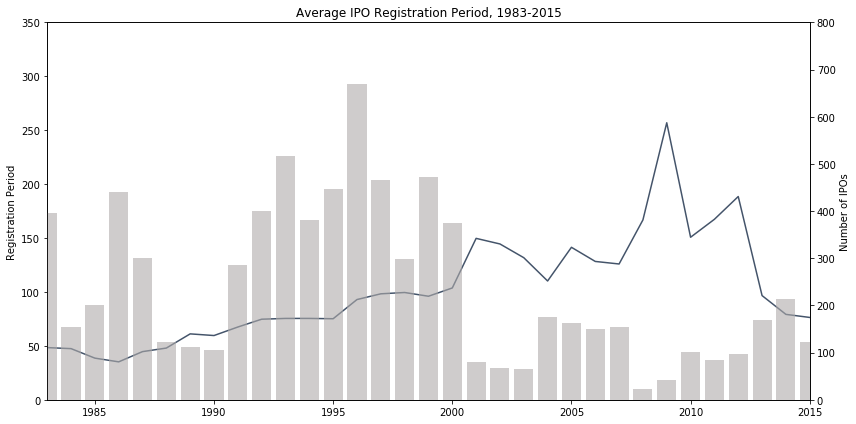

In [153]:
def figure_10(df):
    """
    function to create figure 10
    """
    fig, ax1 = plt.subplots()
    fig.set_size_inches(12, 6)
    ax1.plot(df['Year'], df['rp'], c='#44546a')
    ax1.set_title('Average IPO Registration Period, 1983-2015')
    ax1.set_ylabel('Registration Period')
    ax1.set_ylim([0,350])
    ax1.set_xlim([1983, 2015])
    #vals = ax1.get_yticks()
    #ax1.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

    ax2 = ax1.twinx()
    ax2.bar(df['Year'].values, height=df['IPO'].values, color='#afabab', alpha=0.6)
    ax2.set_ylabel('Number of IPOs')
    ax2.set_ylim([0,800])
    
    fig.tight_layout()
    plt.savefig(plot_path + 'figure10.png', dpi=300)
    plt.show()

figure_10(df = table_7)

### <font color='grey'> [NO REPLICATION] Figure 11. Registration Period and Number of SEC letters. </font>

chart won't be replicated because of the needed SEC data from EDGAR.


### Figure 12. Monthly and Weekly Paterns of the IPO Date.

In [154]:
# create month and weekdays columns
data['First_CRSP_date'] = pd.to_datetime(data['First_CRSP_date'], format='%Y-%m-%d')
data['month'] = data['First_CRSP_date'].dt.month_name()
data['month_nr'] = data['First_CRSP_date'].dt.month
data['weekday'] = data['First_CRSP_date'].dt.weekday_name
data['weekday_nr'] = data['First_CRSP_date'].dt.weekday

# create data table for figure 12a
Table_Fig_12_a = data.groupby('month').agg(
    num_ipo = ('IPO', 'count'),
    month_nr = ('month_nr', np.mean))
Table_Fig_12_a = Table_Fig_12_a.sort_values('month_nr')

# create data table for figure 12b
Table_Fig_12_b = data.groupby('weekday').agg(
    num_ipo = ('IPO', 'count'),
    weekday_nr = ('weekday_nr', np.mean))
Table_Fig_12_b = Table_Fig_12_b.sort_values('weekday_nr')

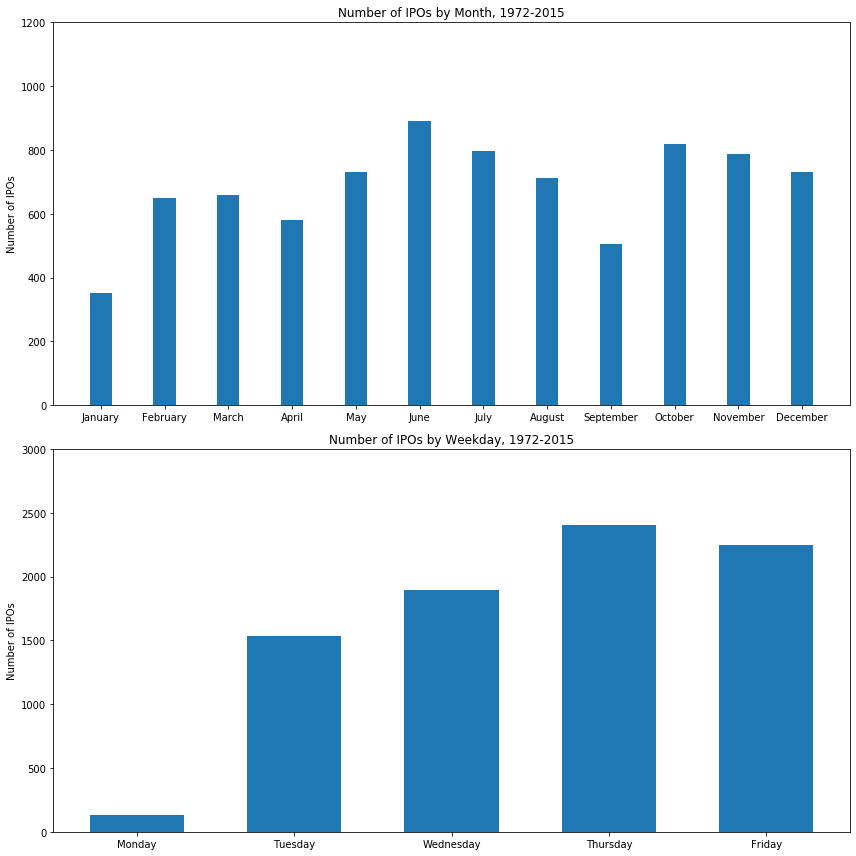

In [155]:
# Figure 12
def figure_12(df, df2):
    fig, axs = plt.subplots(2)
    fig.set_size_inches(12, 12)
    axs[0].set_title('Number of IPOs by Month, 1972-2015')
    axs[0].set_ylabel('Number of IPOs')
    axs[0].set_ylim([0,1200])
    axs[0].bar(np.arange(12), df['num_ipo'], width=0.35)
    axs[0].set_xticks(np.arange(12))
    axs[0].set_xticklabels(df.index)
    #axs[0].plt.xticks(np.arange(12), df.index)
    
    axs[1].set_title('Number of IPOs by Weekday, 1972-2015')
    axs[1].set_ylabel('Number of IPOs')
    axs[1].set_ylim([0,3000])
    axs[1].bar(np.arange(5), df2['num_ipo'], width=0.6)
    axs[1].set_xticks(np.arange(5))
    axs[1].set_xticklabels(df2.index)
    
    fig.tight_layout()
    plt.savefig(plot_path + 'figure10.png', dpi=300)
    plt.show()

figure_12(df = Table_Fig_12_a, df2 = Table_Fig_12_b)  

### Table 8. Dynamics of the Average Offer IPO Price.

In [156]:
# create variables for offer price depending on the proceed size
data.loc[data['size'] == 'S', 'op_s'] = data['OfferPrice']
data.loc[data['size'] == 'M', 'op_m'] = data['OfferPrice']
data.loc[data['size'] == 'L', 'op_l'] = data['OfferPrice']

# create table 8 structure and content
table_8 = data.groupby(['Year']).agg(
    IPO = ('IPO', 'count'),
    op = ('OfferPrice', np.mean),
    op_s = ('op_s', np.mean),
    op_m = ('op_m', np.mean),
    op_l = ('op_l', np.mean))

table_8 = table_8.reset_index()

# take only data since 1980
table_8 = table_8.loc[table_8['Year']>=1980, :]

# show table
table_8

,Year,IPO,op,op_s,op_m,op_l
7,1980,52,14.478365,11.036290,18.986111,23.000000
8,1981,150,12.396667,10.503788,15.789062,20.583333
9,1982,60,12.154167,10.212500,15.776316,21.000000
10,1983,395,12.886266,10.177778,14.955303,18.976562
11,1984,155,9.568548,8.834430,11.296053,15.583333
12,1985,200,10.647500,8.836614,13.308333,16.057692
13,1986,440,11.419943,9.347211,13.293548,18.180147
14,1987,301,11.210282,9.009509,12.925420,19.348421
15,1988,123,10.891057,8.990132,12.796053,18.900000
16,1989,112,11.785312,8.523438,13.342593,19.033000


### <font color='red'> [NOT RIGHT YET]</font> Figure 13. Dynamics of Nominal IPO Offer Price. 

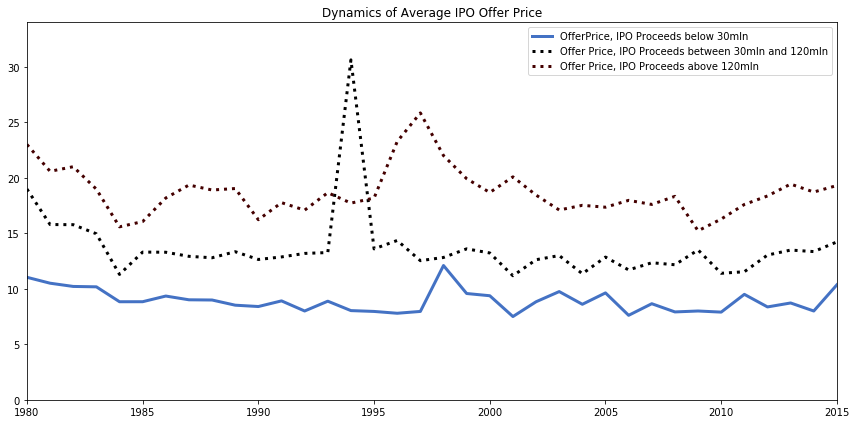

In [157]:
def figure_13(df, linewidth):
    """
    function to create figure 13
    """

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 6)
    ax.set_title('Dynamics of Average IPO Offer Price')
    ax.set_ylim([0,34])
    ax.set_xlim([1980, 2015])
    ln1 = ax.plot(df['Year'], df['op_s'], c='#4472c4', 
                   linewidth=linewidth, 
                   label='OfferPrice, IPO Proceeds below 30mln')
    ln2 = ax.plot(df['Year'], df['op_m'], 
                   c='#000000', linewidth=linewidth, linestyle=':',
                   label='Offer Price, IPO Proceeds between 30mln and 120mln')
    ln3 = ax.plot(df['Year'], df['op_l'], 
                   c='#440000', linewidth=linewidth, linestyle=':',
                   label='Offer Price, IPO Proceeds above 120mln')
    ax.legend()
    
    fig.tight_layout()
    plt.savefig(plot_path + 'figure13.png', dpi=300)
    plt.show()

linewidth = 3
figure_13(df = table_8, linewidth=linewidth)

### Table 9. IPO Delisting for Poor Performance and Acquisition, 1972-2015.

### get CRSP Stock Header Information
1. print PERMNO_txt_File with all used PERMNO
2. go to wrds for CRSP Stock Header Information 
   Link: https://wrds-web.wharton.upenn.edu/wrds/ds/crsp/stock_a/stkhdr.cfm?navId=128
3. download all information for the PERMNOs in in the Permno txt file
4. put the file into the initial_data folder and call it 'PERMNO_CRSP_header_information.csv'

In [158]:
# create the Permno_list.txt for wrds data extraction
create_PERMNO_txt_file(df=data, column='PERMNO', file_name='PERMNO_list', path=cleaned_folder_path)

In [185]:
def create_table_9(df):
    # read crsp stock header information 
    crsp_info = pd.read_csv(initial_folder_path + 'PERMNO_CRSP_Stock_header_information.csv')
    crsp_info = crsp_info.sort_values(['permno', 'BEGDAT'])

    # merge crsp info to data
    df = pd.merge(df, crsp_info, how='left', left_on='PERMNO', right_on='permno')
    df['ENDPRC'] = pd.to_datetime(df['ENDPRC'], format='%Y%m%d')
    
    # create needed columns
    for column in ['Poor_perf', 'Acq', 'Poor_perf3', 
               'Poor_perf5', 'Poor_perf10', 
               'Acq3', 'Acq5', 'Acq10']:
        df[column] = 0
    
    # calculate poor perfomance and acquisistion variables 
    df.loc[(df['DLSTCD'] >= 400) & (df['DLSTCD'] < 600), 'Poor_perf'] = 1
    df.loc[(df['DLSTCD'] >= 200) & (df['DLSTCD'] < 400), 'Acq'] = 1
    
    df['active_duration'] = (df['ENDPRC'] - df['IssueDate']).dt.days
    df.loc[(df['active_duration'] < 3*365) & (df['Poor_perf'] == 1), 'Poor_perf3'] = 1
    df.loc[(df['active_duration'] < 5*365) & (df['Poor_perf'] == 1), 'Poor_perf5'] = 1
    df.loc[(df['active_duration'] < 10*365) & (df['Poor_perf'] == 1), 'Poor_perf10'] = 1
    
    df.loc[(df['active_duration'] < 3*365) & (df['Acq'] == 1), 'Acq3'] = 1
    df.loc[(df['active_duration'] < 5*365) & (df['Acq'] == 1), 'Acq5'] = 1
    df.loc[(df['active_duration'] < 10*365) & (df['Acq'] == 1), 'Acq10'] = 1
    
    # exclude IPOs in the most recent 3/5/10 years from the tables
    today = pd.to_datetime('2015-12-31', format='%Y-%m-%d')
    df['timetotoday'] = (today - df['IssueDate']).dt.days
    df.loc[df['timetotoday'] < (3*365), 'Poor_perf3'] = np.nan
    df.loc[df['timetotoday'] < 3*365, 'Acq3'] = np.nan
    df.loc[df['timetotoday'] < 5*365, 'Poor_perf5'] = np.nan
    df.loc[df['timetotoday'] < 5*365, 'Acq5'] = np.nan
    df.loc[df['timetotoday'] < 10*365, 'Poor_perf10'] = np.nan
    df.loc[df['timetotoday'] < 10*365, 'Acq10'] = np.nan
    
    # create table 9 structure and content
    table_9 = df.groupby(['Year']).agg(
        IPO = ('IPO', 'count'),
        del3 = ('Poor_perf3', np.mean),
        del5 = ('Poor_perf5', np.mean),
        del10 = ('Poor_perf10', np.mean),
        acq3 = ('Acq3', np.mean),
        acq5 = ('Acq5', np.mean),
        acq10 = ('Acq10', np.mean))

    table_9 = table_9.reset_index()

    # take only data between 1973 to 2013
    table_9 = table_9.loc[(table_9['Year']>=1973) & (table_9['Year']<=2013), :]

    return table_9

In [186]:
table_9 = create_table_9(data)
table_9

,Year,IPO,del3,del5,del10,acq3,acq5,acq10
0,1973,13,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000
1,1974,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333
2,1975,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1976,13,0.000000,0.000000,0.000000,0.076923,0.153846,0.307692
4,1977,10,0.000000,0.000000,0.000000,0.200000,0.300000,0.600000
5,1978,17,0.000000,0.000000,0.000000,0.117647,0.176471,0.294118
6,1979,34,0.000000,0.029412,0.117647,0.058824,0.147059,0.352941
7,1980,52,0.019231,0.019231,0.153846,0.038462,0.057692,0.250000
8,1981,150,0.046667,0.086667,0.193333,0.040000,0.126667,0.340000
9,1982,60,0.033333,0.033333,0.116667,0.083333,0.166667,0.350000


### Figure 14. Delisting and Acquisition of the Companies after IPO.

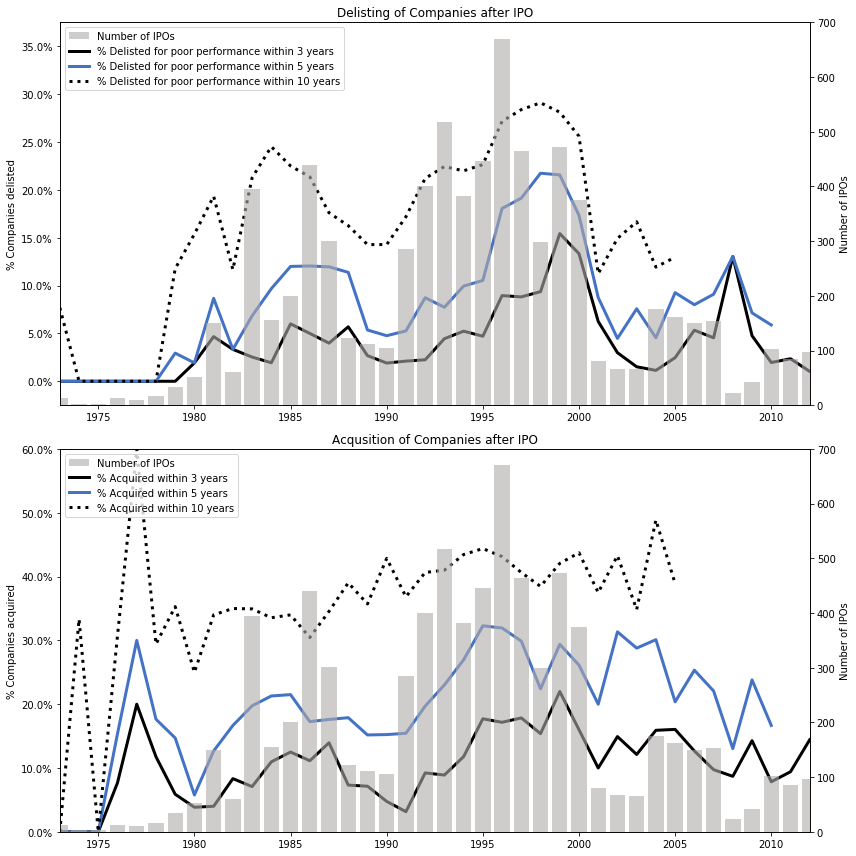

In [194]:
def figure_14(df, linewidth=3):
    """
    function to create figure 14a and 14b
    """
    fig, ax1 = plt.subplots(2)
    fig.set_size_inches(12, 12)
    
    # figure 14a
    ln1 = ax1[0].plot(df['Year'], df['del3'], c='#000000', 
                   linewidth=linewidth, 
                   label='% Delisted for poor performance within 3 years')
    ln2 = ax1[0].plot(df['Year'], df['del5'], 
                   c='#4472c4', linewidth=linewidth,
                   label='% Delisted for poor performance within 5 years')
    ln3 = ax1[0].plot(df['Year'], df['del10'], 
                   c='#000000', linewidth=linewidth, linestyle=':',
                   label='% Delisted for poor performance within 10 years')
    
    ax1[0].set_title('Delisting of Companies after IPO')
    ax1[0].set_ylabel('% Companies delisted')
    ax1[0].set_ylim([-0.025,0.375])
    ax1[0].set_xlim([1973, 2012])
    vals = ax1[0].get_yticks()
    ax1[0].set_yticklabels(['{:,.1%}'.format(x) for x in vals])

    ax2 = ax1[0].twinx()
    bar1 = ax2.bar(df['Year'].values, height=df['IPO'].values, 
                   color='#afabab', alpha=0.6, 
                   label='Number of IPOs')
    ax2.set_ylabel('Number of IPOs')
    ax2.set_ylim([0,700])
    
    lines, labels = ax1[0].get_legend_handles_labels()
    bars, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(bars + lines, labels2 + labels, loc='upper left')
    
    # figure 14b
    ln1b = ax1[1].plot(df['Year'], df['acq3'], c='#000000', 
                   linewidth=linewidth, 
                   label='% Acquired within 3 years')
    ln2b = ax1[1].plot(df['Year'], df['acq5'], 
                   c='#4472c4', linewidth=linewidth,
                   label='% Acquired within 5 years')
    ln3b = ax1[1].plot(df['Year'], df['acq10'], 
                   c='#000000', linewidth=linewidth, linestyle=':',
                   label='% Acquired within 10 years')
    
    ax1[1].set_title('Acqusition of Companies after IPO')
    ax1[1].set_ylabel('% Companies acquired')
    ax1[1].set_ylim([0,0.6])
    ax1[1].set_xlim([1973, 2012])
    vals = ax1[1].get_yticks()
    ax1[1].set_yticklabels(['{:,.1%}'.format(x) for x in vals])

    ax2b = ax1[1].twinx()
    bar1b = ax2b.bar(df['Year'].values, height=df['IPO'].values, 
                   color='#afabab', alpha=0.6, 
                   label='Number of IPOs')
    ax2b.set_ylabel('Number of IPOs')
    ax2b.set_ylim([0,700])
    
    linesb, labelsb = ax1[1].get_legend_handles_labels()
    barsb, labels2b = ax2b.get_legend_handles_labels()
    ax2b.legend(barsb + linesb, labels2b + labelsb, loc='upper left')
    
    fig.tight_layout()
    plt.savefig(plot_path + 'figure14.png', dpi=300)
    plt.show()

linewidth=3
figure_14(df = table_9, linewidth=linewidth)

### Table 10. 3-year and 5-year post-IPO buy and hold returns (similar to Loughran and Ritter 1995, Table 4).

### Table 11. Calendar time portfolio post-IPO returns.

In [218]:
# read fama_french
fama_french = pd.read_csv(initial_folder_path + 'F-F_Research_Data_Factors_daily.csv', skiprows=4, delimiter=',')

### loading Fama-French data:       <font color='red'> [get four-factor data] </font>

In [219]:
# set column names
fama_french.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RF']

# drop last line (copyright line)
fama_french = fama_french[:-1]

fama_french['Date'] = pd.to_datetime(fama_french['Date'], format='%Y%m%d')


In [220]:
ff_columns = fama_french.columns[1:]
for col in ff_columns:
    fama_french.loc[:, col]= 100*fama_french.loc[:, col]

In [221]:
fama_french

,Date,Mkt-RF,SMB,HML,RF
0,1926-07-01,10.0,-24.0,-28.0,0.9
1,1926-07-02,45.0,-32.0,-8.0,0.9
2,1926-07-06,17.0,27.0,-35.0,0.9
3,1926-07-07,9.0,-59.0,3.0,0.9
4,1926-07-08,21.0,-36.0,15.0,0.9
...,...,...,...,...,...
24617,2019-11-22,24.0,5.0,25.0,0.6
24618,2019-11-25,92.0,130.0,-39.0,0.6
24619,2019-11-26,19.0,5.0,-81.0,0.6
24620,2019-11-27,44.0,23.0,-5.0,0.6


In [ ]:
years3 <- NULL
years3[[1]] <- 1973:2013
years3[[2]] <- 1973:1979
years3[[3]] <- 1980:1989
years3[[4]] <- 1990:1999
years3[[5]] <- 2000:2013